## Config

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

In [112]:
df_train = pd.read_parquet('M3_yearly_processed_v2.parquet')

In [113]:
df_train

,Series,N,NF,Category,Value,Date
0,1,20,6,MICRO,940.66,1975-01-01
1,1,20,6,MICRO,1084.86,1976-01-01
2,1,20,6,MICRO,1244.98,1977-01-01
3,1,20,6,MICRO,1445.02,1978-01-01
4,1,20,6,MICRO,1683.17,1979-01-01
...,...,...,...,...,...,...
18314,645,38,6,OTHER,7343.00,1988-01-01
18315,645,38,6,OTHER,5730.00,1989-01-01
18316,645,38,6,OTHER,5007.00,1990-01-01
18317,645,38,6,OTHER,4715.00,1991-01-01


In [114]:
def read_all_sheets(excel_path):
    """
    Reads all sheets from an Excel file and combines them into a single DataFrame.
    
    Args:
    - excel_path (str): The path to the Excel file.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the combined data from all sheets.
    """
    # Use pandas to read the Excel file and get sheet names
    xls = pd.ExcelFile(excel_path)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Iterate over all sheet names
    for sheet_name in xls.sheet_names:
        # Read the current sheet into a DataFrame
        df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        
        # Optionally, add a column to indicate the source sheet, if needed
        df['Sheet'] = sheet_name
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list into one
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

# Usage
excel_path = '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M-Competitions/M3-Competition/M3Forecast.xls'
combined_df = read_all_sheets(excel_path)

In [115]:
# Rename columns
combined_df.rename(columns = {0 : 'Series', 1 : 'NF'}, inplace = True)

# Change series to int in the same fashion as the other dataframes
combined_df['Series'] = combined_df['Series'].str.replace('N', '')
combined_df['Series'] = combined_df['Series'].str.replace(' ', '')
combined_df['Series'] = combined_df['Series'].astype(int)

# Change position of sheet column
cols = combined_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
combined_df = combined_df[cols]

# Rename columns so that 1 is the first forecast period
combined_df.rename(columns=lambda x: x - 1 if isinstance(x, int) else x, inplace=True)

# Melt the dataframe i.e. unpivot
df_long = pd.melt(combined_df, id_vars=['Sheet', 'NF' , 'Series'], value_name='value', var_name='ForecastPeriod')   

# Sort the dataframe
df_long_sorted = df_long.sort_values(by=['Sheet', 'Series', 'ForecastPeriod'])
# df_long_sorted.head()

## Test with one example and verify for each metric that this works

In [116]:
df_long_sorted.dropna(subset=['value'], inplace=True)

In [117]:
df_test = df_long_sorted.loc[(df_long_sorted['Sheet'] == 'ARARMA') & (df_long_sorted['Series'] <= 645)]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3870 entries, 33033 to 385847
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sheet           3870 non-null   object 
 1   NF              3870 non-null   int64  
 2   Series          3870 non-null   int64  
 3   ForecastPeriod  3870 non-null   object 
 4   value           3870 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 181.4+ KB


In [119]:
top6_per_series = df_train.groupby('Series').apply(lambda x: x.nlargest(6, 'Date')).reset_index(drop=True)

top6_per_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Series    3870 non-null   int64         
 1   N         3870 non-null   int64         
 2   NF        3870 non-null   int64         
 3   Category  3870 non-null   object        
 4   Value     3870 non-null   float64       
 5   Date      3870 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 181.5+ KB


<ipython-input-119-7ed75b988aeb>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top6_per_series = df_train.groupby('Series').apply(lambda x: x.nlargest(6, 'Date')).reset_index(drop=True)


In [128]:
top6_per_series

,Series,N,NF,Category,Value,Date
0,1,20,6,MICRO,9156.01,1994-01-01
1,1,20,6,MICRO,8407.84,1993-01-01
2,1,20,6,MICRO,7851.91,1992-01-01
3,1,20,6,MICRO,6876.58,1991-01-01
4,1,20,6,MICRO,6158.68,1990-01-01
...,...,...,...,...,...,...
3865,645,38,6,OTHER,4715.00,1991-01-01
3866,645,38,6,OTHER,5007.00,1990-01-01
3867,645,38,6,OTHER,5730.00,1989-01-01
3868,645,38,6,OTHER,7343.00,1988-01-01


In [135]:
def smape(a, f):
    a = np.array(a)
    f = np.array(f)
    return sum(np.abs(a - f) / ((a + f) / 2)) * 100

smape(top6_per_series['Value'], df_test['value'])

84155.79132144107

In [136]:
act = [9156.01]
pred = [8153.15]
print(smape(act, pred))

11.587621814114614


In [137]:
def smape(a, f):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE).

    Args:
    - a (np.array): Array of actual values.
    - f (np.array): Array of forecast values.

    Returns:
    - float: The SMAPE value.
    """
    return sum(np.abs(a - f) / ((a + f) / 2)) * 100

# Initialize an empty DataFrame to store SMAPE results
smape_results = []

# Iterate through each unique series
for series in top6_per_series['Series'].unique():
    # For each step from 1 to 6
    for step in range(1, 7):
        # Assuming 'Step' is used in df_test to denote forecast steps
        # Ensure the actuals and forecasts are aligned by their steps
        actuals = top6_per_series[top6_per_series['Series'] == series].sort_values(by='Date', ascending=False).head(step)['Value'].values
        if len(actuals) < step:  # If fewer actuals than step, skip to ensure correct alignment
            continue
        forecasts = df_test[(df_test['Series'] == series) & (df_test['ForecastPeriod'] == step)]['value'].values
        if len(forecasts) == 0:  # If no forecast for this step, skip
            continue
        
        # Calculate SMAPE for the series and step
        smape_value = smape(actuals[-1:], forecasts)  # Compare the last actual value with the forecast for the step

        # Append the result to the DataFrame
        smape_results.append({
            'Series': series, 
            'Step': step, 
            'SMAPE': smape_value})
        
smape_results = pd.DataFrame(smape_results)

# smape_results now contains the SMAPE for each series and step


In [139]:
smape_results.groupby('Step')['SMAPE'].mean()

Step
1    23.559472
2    21.827938
3    19.352026
4    19.584504
5    21.059536
6    25.090620
Name: SMAPE, dtype: float64

In [64]:
df_train.head(20)

,Series,N,NF,Category,Value,Date
0,1,20,6,MICRO,940.66,1975-01-01
1,1,20,6,MICRO,1084.86,1976-01-01
2,1,20,6,MICRO,1244.98,1977-01-01
3,1,20,6,MICRO,1445.02,1978-01-01
4,1,20,6,MICRO,1683.17,1979-01-01
5,1,20,6,MICRO,2038.15,1980-01-01
6,1,20,6,MICRO,2342.52,1981-01-01
7,1,20,6,MICRO,2602.45,1982-01-01
8,1,20,6,MICRO,2927.87,1983-01-01
9,1,20,6,MICRO,3103.96,1984-01-01


In [65]:
methods = ['AutomatANN', 'DAMPEN', 'COMB S-H-D', 'AUTOBAX-2', 'ROBUST-TREND', 'ARARMA',
           'FLORES-PEARCE-1', 'PP-Autocast', 'ForecastPRO', 'SMARTFCS', 'THETA', 'RBF',
           'ForcX']

In [73]:
def calc_smape(df_actual, df_forecast, methods):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) for each forecast step.
    
    Args:
    - df_actual (pd.DataFrame): A DataFrame containing the actual values.
    - df_forecast (pd.DataFrame): A DataFrame containing the forecast values.
    
    Returns:
    - pd.DataFrame: A DataFrame with SMAPE values for each forecast method and series.
    """
    results = []
    for method in methods:
        for series in range(1, 646):  # Assuming series is a meaningful index for comparison
            # Assuming you have a way to match actuals and forecasts based on series and method
            # This part of the code needs to be adjusted to your data structure
            # For example, filtering df_actual and df_forecast based on series (and possibly method)
            # I'm adding placeholders for filtering based on assumed structure
            df_filtered_actual = df_actual[df_actual['Series'] == series]
            df_filtered_forecast = df_forecast[(df_forecast['Sheet'] == method) & (df_forecast['Series'] == series)]
            
            # Check if there's data to compare
            if not df_filtered_actual.empty and not df_filtered_forecast.empty:
                for x in range(1, 6+1):
                    actuals = np.array(df_filtered_actual['Value'].tail(x))
                    forecast = np.array(df_filtered_forecast['value'].head(x))
                
                # Calculate SMAPE
                    smape = 1/len(actuals) * np.sum(2 * np.abs(forecast-actuals) / (np.abs(actuals) + np.abs(forecast))*100)
                
                    results.append({
                        'Method': method,
                        'Series': series,
                        'SMAPE': smape,
                        'Step' : x
                    })

    results_df = pd.DataFrame(results)
    return results_df


In [74]:
test1 = calc_smape(df_train, df_long_sorted, methods)
print("Hello world!")

Hello world!


In [77]:
test1.loc[(test1['Method'] == 'DAMPEN') & (test1['Series'] == 29)]

,Method,Series,SMAPE
168,DAMPEN,29,22.004900
169,DAMPEN,29,48.606819
170,DAMPEN,29,76.106151
171,DAMPEN,29,104.859357
172,DAMPEN,29,122.936091
173,DAMPEN,29,134.663772


In [78]:
test1['Step'] = np.tile(np.arange(1, 7), len(test1) // 6 + 1)[:len(test1)]

In [82]:
mean_smape_by_method = test1.groupby('Method')['SMAPE'].mean()
mean_smape_by_method

Method
ARARMA         20.790318
COMB S-H-D     20.726155
DAMPEN         20.603596
ForcX          20.303319
PP-Autocast    20.456478
RBF            20.332032
SMARTFCS       20.965613
THETA          20.465405
Name: SMAPE, dtype: float64

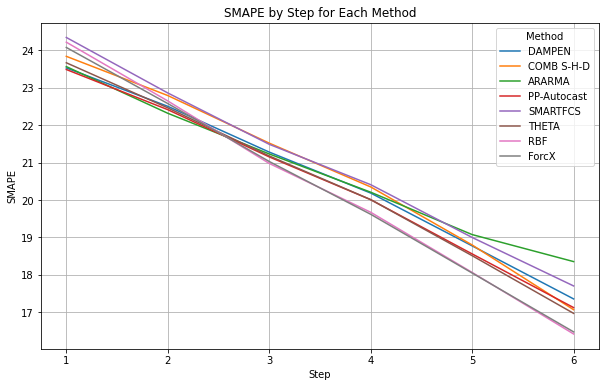

In [81]:

plt.figure(figsize=(10, 6))

# Get unique methods from the 'Method' column
methods = test1['Method'].unique()

# Iterate through each method and plot it
for method in methods:
    method_data = test1[test1['Method'] == method]
    # Group by 'Step' and calculate the mean 'SMAPE' for each step
    mean_smape_by_step = method_data.groupby('Step')['SMAPE'].mean()
    plt.plot(mean_smape_by_step.index, mean_smape_by_step, label=method)

plt.xlabel('Step')
plt.ylabel('SMAPE')
plt.title('SMAPE by Step for Each Method')
plt.legend(title='Method')
plt.grid(True)
plt.show()